In [1]:
import pennylane as qml
import numpy as np
import jax.numpy as jnp
import jax
import optax

jax.config.update("jax_enable_x64", True)

from time import time

import matplotlib.pyplot as plt

from functools import partial
from datetime import datetime

from copy import copy

from util import run_opt, run_opt_jit, _timeit, get_pulse_gates
import concurrent.futures
import multiprocessing as mp

In [2]:
bond_distance = 1.0
dataset = qml.data.load("qchem", molname="H4", basis="STO-3G", bondlength=bond_distance)[0]
E_exact = dataset.fci_energy
E_vqe = dataset.vqe_energy
target_full = dataset.vqe_gates[-1]
wires = target_full.wires

In [97]:
for op in dataset.vqe_gates:
    print(op)

DoubleExcitation(0.12953951447619957, wires=[0, 1, 4, 5])
DoubleExcitation(0.08645931650931196, wires=[0, 1, 6, 7])
DoubleExcitation(-0.0560693522180852, wires=[0, 2, 4, 6])
DoubleExcitation(0.14201007828464737, wires=[0, 3, 4, 7])
DoubleExcitation(-0.08442698379691183, wires=[0, 3, 5, 6])
DoubleExcitation(-0.08445378599628901, wires=[1, 2, 4, 7])
DoubleExcitation(0.14462010817824916, wires=[1, 2, 5, 6])
DoubleExcitation(-0.05538447269303341, wires=[1, 3, 5, 7])
DoubleExcitation(0.38545939665561746, wires=[2, 3, 4, 5])
DoubleExcitation(0.08745342238055516, wires=[2, 3, 6, 7])
SingleExcitation(0.016525170271960314, wires=[0, 4])
SingleExcitation(-0.016157391695060894, wires=[1, 5])
SingleExcitation(-0.010906162686849732, wires=[2, 6])
SingleExcitation(0.01134013966882094, wires=[3, 7])


In [3]:
atol = 1e-12
tbins = 10
time_scaling = 1.
n_epochs = 1000
max_workers = 8 # laptop: 10, cluster: 8

T_single = 20.
T_CR = 100.

# https://arxiv.org/pdf/1905.05670.pdf
qubit_freq = np.array([6.509, 5.963]) # slower qubit rotations for faster simulation
#qubit_freq = np.array([1.1, 0.9])

H_single, H_single0, H_single1, H_CR0, H_CR1 = get_pulse_gates(wires, T_single=T_single, T_CR=T_CR, qubit_freq=qubit_freq)

In [4]:
n_params = 5 # number of gates
n_wires = len(wires)

neg_mask = jnp.concatenate([-jnp.ones(tbins), jnp.ones(tbins)]) # negative amplitudes, intact phases

@qml.qnode(qml.device("default.qubit.jax", wires=dataset.hamiltonian.wires), interface="jax")
def loss(params):
    qml.BasisState([_.item() for _ in dataset.hf_state], wires = dataset.hamiltonian.wires)
    for op in dataset.vqe_gates[:-1]:
        qml.apply(op)
    for op in dataset.vqe_gates[-1].decomposition()[:-7]:
        qml.apply(op)
    qml.evolve(H_single)((params[0], params[1]), t=T_single, atol=atol)

    qml.evolve(H_CR1)((params[2],), t=T_CR, atol=atol)
    qml.PauliX(wires[1])
    qml.evolve(H_CR1)((neg_mask*params[2],), t=T_CR, atol=atol)
    qml.PauliX(wires[1])

    qml.evolve(H_single)((params[3], params[4]), t=T_single, atol=atol)
    return qml.expval(dataset.hamiltonian)

trivial_diff = loss(jnp.zeros((n_params, 2*tbins))) - dataset.fci_energy
trivial_diff

Array(0.60072027, dtype=float64)

In [5]:
seeds = tuple(range(max_workers//2))

# hyper_params = [(seeds[i], 0.0001) for i in range(len(seeds))]
# hyper_params = [(seeds[i], 0.001) for i in range(len(seeds))]
hyper_params = [(seeds[i], 0.1) for i in range(len(seeds))]
hyper_params += [(seeds[i], 0.01) for i in range(len(seeds))]
# hyper_params += [(seeds[i], 0.001) for i in range(len(seeds))]

In [13]:
value_and_grad_jax = jax.jit(jax.value_and_grad(loss))

dt_jit, dt, ddt = _timeit(value_and_grad_jax, jnp.ones((n_params, tbins * 2)))
print(f"jit time {dt_jit}")
print(f"estimated time for optimization: ({dt*n_epochs/60} +/- {ddt*n_epochs/60}) min.")

jit time 27.712092999999996
estimated time for optimization: (18.467379999999995 +/- 0.09012739064481824) min.


In [7]:
def _wrap_run_job(hyper_params):
    seed, lr = hyper_params
    key = jax.random.PRNGKey(seed)
    theta = 1.*jax.random.normal(key, shape=(n_params, tbins * 2))
    thetaf, energy, gradients = run_opt(value_and_grad_jax, theta, lr=lr, verbose=True, n_epochs=n_epochs, E_exact=E_exact)
    np.savez(f"data/VQE_partial_H4-{seed}-lr-{lr}-tbins-{tbins}_n-epochs-{n_epochs}", theta=thetaf, energy=energy, gradients=gradients)

In [8]:
# Setting mp_context=mp.get_context('fork') is necessary on python>3.8 and MacOS
# https://stackoverflow.com/questions/64501481/python-concurrent-futures-processpoolexecutor-and-global-variables-works-on-lin
with concurrent.futures.ProcessPoolExecutor(max_workers=max_workers, mp_context=mp.get_context('fork')) as executor:
   exec_map = executor.map(_wrap_run_job, hyper_params)
   tuple(circuit for circuit in exec_map)

final loss: 0.0008088316703358522; min loss: 0.0008088316703358522; after 0:18:54.671180
final loss: 0.0008413108636635691; min loss: 0.0008413108636635691; after 0:18:57.556348
final loss: 0.0008690723367661413; min loss: 0.0008690723367661413; after 0:18:58.214991
final loss: 0.0008317441387930558; min loss: 0.0008317441387930558; after 0:19:00.974293
final loss: 0.004677388204392674; min loss: 0.0007781733622969078; after 0:19:06.892761
final loss: 0.0010179224887165716; min loss: 0.000833962242480002; after 0:19:09.213281
final loss: 0.006142570996148677; min loss: 0.0008120876930801657; after 0:19:10.073469
final loss: 0.0008566006714691987; min loss: 0.0008215954079120458; after 0:19:11.891718


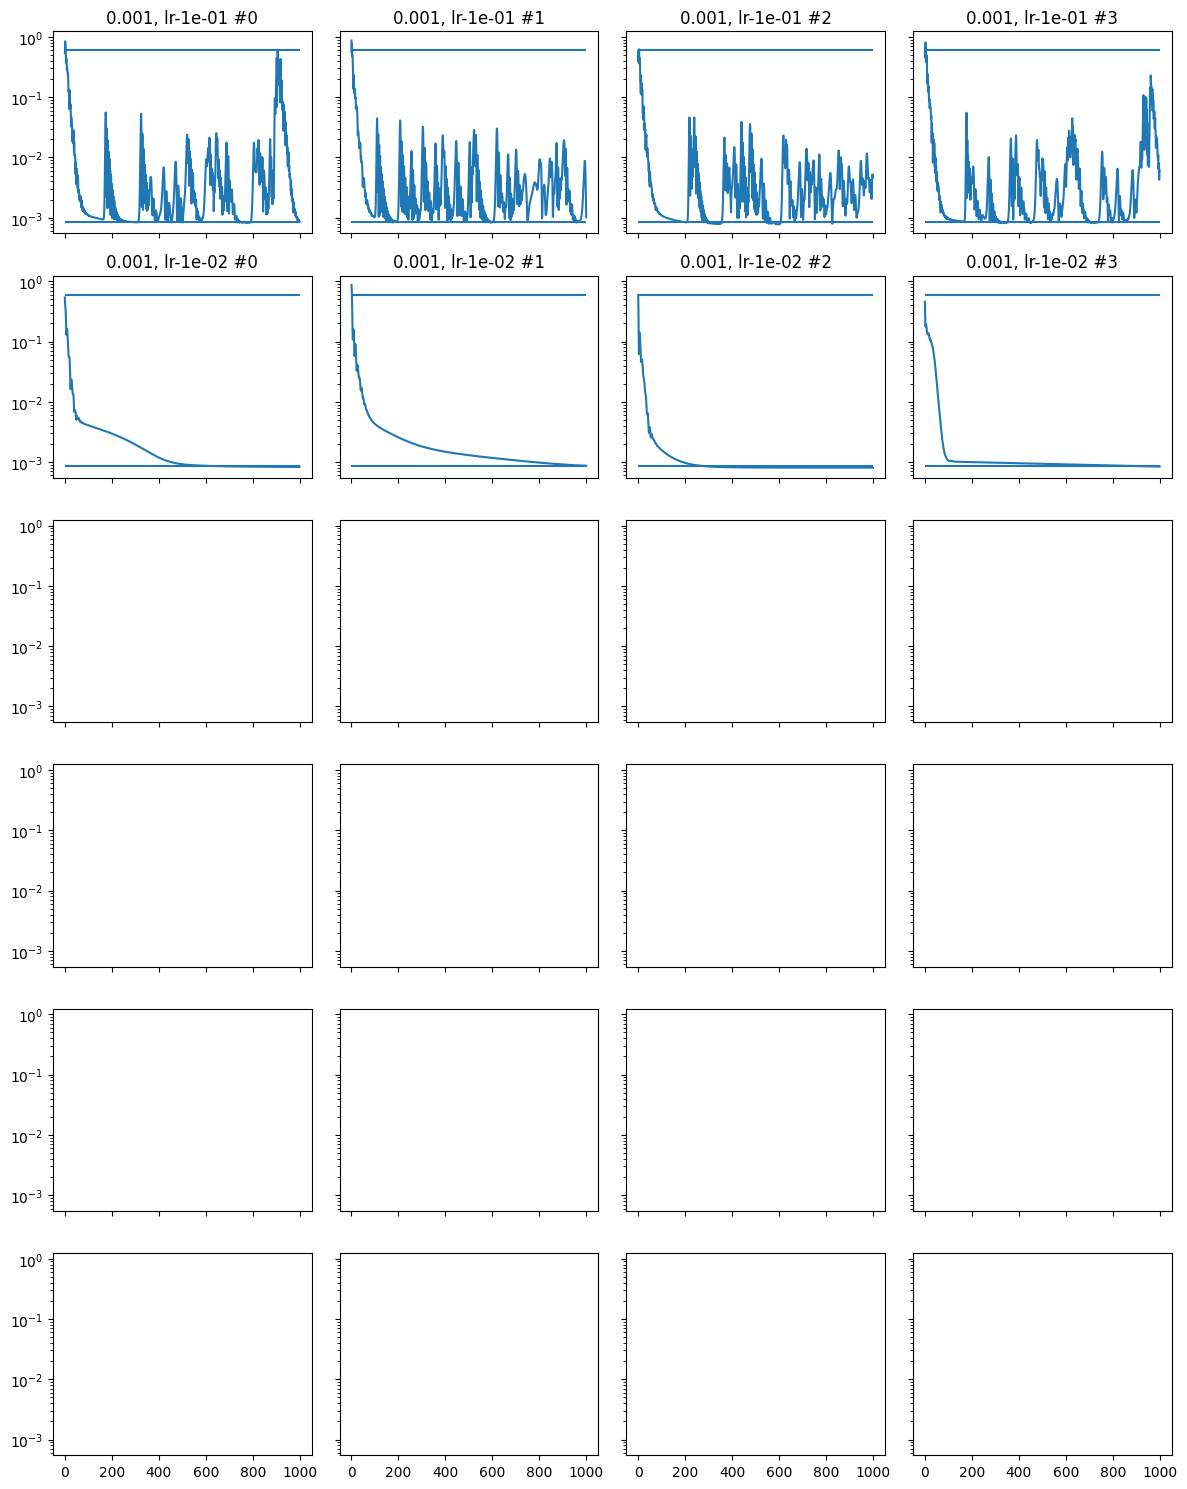

In [6]:
ncols=4
fig, axs = plt.subplots(ncols=4, nrows=6, figsize=(12,15), sharey=True, sharex=True)

# axs[0, 0].text(10, 1e-2, f"T_CR {T_CR} T_single {T_single}")
# axs[0, 0].text(10, 10**(-2.5), f"n_params {n_params} tbins {tbins}")

for i,hyp in enumerate(hyper_params):
    seed, lr = hyp
    name = f"data/VQE_partial_H4-{seed}-lr-{lr}-tbins-{tbins}_n-epochs-{n_epochs}"
    data = np.load(name + ".npz", allow_pickle=True)
    energy, thetaf = data["energy"], data["theta"]
    energy -= E_exact
    emin = np.min(energy)

    ax = axs[i//ncols, i%ncols]
    ax.plot(energy)
    ax.hlines([trivial_diff, E_vqe - E_exact], 0, 1000)
    
    ax.set_yscale("log")
    ax.set_title(f"{emin:.3f}, lr-{lr:.0e} #{seed}")
plt.tight_layout()

In [22]:
# schedule0 = optax.constant_schedule(0.999)
# schedule1 = optax.constant_schedule(0.99)
# schedule = optax.join_schedules([schedule0, schedule1], [100])
n_epochs = 300

seed, lr = 3, 0.1
key = jax.random.PRNGKey(seed)
theta = 1.*jax.random.normal(key, shape=(n_params, tbins * 2))
thetaf, energy, gradients = run_opt(value_and_grad_jax, theta, lr=lr, verbose=True, n_epochs=n_epochs, E_exact=E_exact)
name = f"data/VQE_partial_H4-{seed}-lr-{lr}-tbins-{tbins}_n-epochs-{n_epochs}"
np.savez(name, theta=thetaf, energy=energy, gradients=gradients)

final loss: 0.004088550442771233; min loss: 0.0008732541990110754; after 0:05:27.854362


In [24]:
thetaf, energy, gradients = run_opt(value_and_grad_jax, theta, lr=lr, verbose=True, n_epochs=n_epochs, E_exact=E_exact)
name = f"data/VQE_partial_H4-{seed}-lr-{lr}-tbins-{tbins}_n-epochs-{n_epochs}_restart"
np.savez(name, theta=thetaf, energy=energy, gradients=gradients)

'data/VQE_partial_H4-3-lr-<function join_schedules.<locals>.schedule at 0x161a71f80>-tbins-10_n-epochs-300'

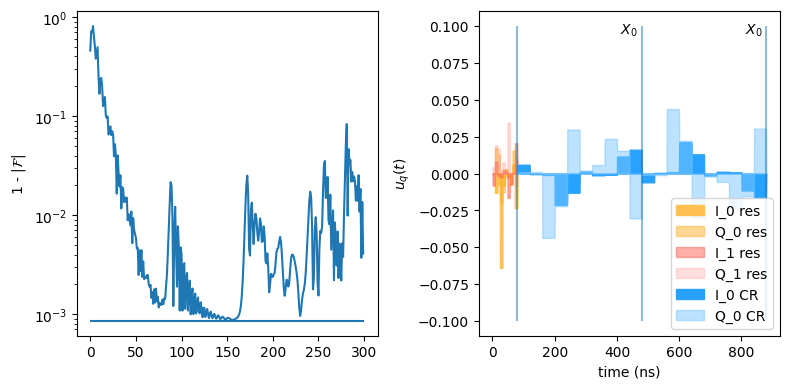

In [25]:
time_stretch = 40.
T_single = 2. * time_stretch
T_CR = 10. * time_stretch

fig, axs = plt.subplots(ncols=2, figsize=(8,4))

# axs[0, 0].text(10, 1e-2, f"T_CR {T_CR} T_single {T_single}")
# axs[0, 0].text(10, 10**(-2.5), f"n_params {n_params} tbins {tbins}")

name = f"data/VQE_partial_H4-{seed}-lr-{lr}-tbins-{tbins}_n-epochs-{n_epochs}"
data = np.load(name + ".npz", allow_pickle=True)
energy, thetas = data["energy"], data["theta"]
emin = np.min(energy)

energy -= E_exact

thetaf = thetas[-1]

ax = axs[0]
ax.plot(energy)
ax.hlines([E_vqe - E_exact], 0, len(energy))

# ax.text(100, 10**(-.5), f"$\\theta \\in$ [{np.min(thetaf[:, :tbins]):.1f} {np.max(thetaf[:, :tbins]):.1f}]")

ax.set_yscale("log")
ax.set_ylabel("1 - |$\\mathcal{F}$|")

ax = axs[1]

t0 = np.linspace(0, T_single, 500)
phit = qml.pulse.pwc(T_single)(thetaf[1, tbins:], t0)
V = qml.pulse.pwc(T_single)(thetaf[1, :tbins], t0) / time_stretch
ax.fill_between(t0, np.sin(phit) * V, label="I_0 res", color="#FFC051")
ax.fill_between(t0, np.cos(phit) * V, label="Q_0 res", alpha=0.5, color="#FFB128")

t0 = np.linspace(0, T_single, 500)
phit = qml.pulse.pwc(T_single)(thetaf[0, tbins:], t0)
V = qml.pulse.pwc(T_single)(thetaf[0, :tbins], t0) / time_stretch
ax.fill_between(t0, np.sin(phit) * V, label="I_1 res", alpha=0.5, color="#FF5E52")
ax.fill_between(t0, np.cos(phit) * V, label="Q_1 res", alpha=0.3, color="#FF938B")

t1 = np.linspace(T_single, T_single + T_CR, 500)
phit = qml.pulse.pwc((T_single, T_single + T_CR))(thetaf[2, tbins:], t1)
V = qml.pulse.pwc((T_single, T_single + T_CR))(thetaf[2, :tbins], t1) / time_stretch
ax.fill_between(t1, np.sin(phit) * V, label="I_0 CR", color="#28A2FF")
ax.fill_between(t1, np.cos(phit) * V, label="Q_0 CR", alpha=0.5, color="#7AC6FF")

t1 = np.linspace(T_single + T_CR, T_single + 2*T_CR, 500)
phit = qml.pulse.pwc((T_single + T_CR, T_single + 2*T_CR))(thetaf[2, tbins:], t1)
V = qml.pulse.pwc((T_single + T_CR, T_single + 2*T_CR))(-thetaf[2, :tbins], t1) / time_stretch
ax.fill_between(t1, np.sin(phit) * V, color="#28A2FF")
ax.fill_between(t1, np.cos(phit) * V, alpha=0.5, color="#7AC6FF")

ax.vlines([T_single, T_single + T_CR, T_single + 2*T_CR], -4/time_stretch, 4/time_stretch, alpha=0.5)
ax.text(T_single + T_CR-70, 3.8/time_stretch, f"$X_0$")
ax.text(T_single + 2*T_CR-70, 3.8/time_stretch, f"$X_0$")
ax.legend(loc=4)
ax.set_xlabel("time (ns)")
ax.set_ylabel("$u_q(t)$")

plt.tight_layout()

# start from actual gate

In [67]:
max_workers = 6
seeds = tuple(range(3))
n_epochs = 300

hyper_params = [(seeds[i], 0.1, n_epochs) for i in range(len(seeds))]
hyper_params += [(seeds[i], 0.01, n_epochs) for i in range(len(seeds))]

In [68]:
atol = 1e-12
tbins = 10
time_scaling = 1.
n_epochs = 1000
max_workers = 8 # laptop: 10, cluster: 8

T_single = 20.
T_CR = 100.

# https://arxiv.org/pdf/1905.05670.pdf
qubit_freq = np.array([6.509, 5.963]) # slower qubit rotations for faster simulation
#qubit_freq = np.array([1.1, 0.9])

H_single, H_single0, H_single1, H_CR0, H_CR1 = get_pulse_gates(wires, T_single=T_single, T_CR=T_CR, qubit_freq=qubit_freq)

In [39]:
n_params = 5 # number of gates
n_wires = len(wires)

neg_mask = jnp.concatenate([-jnp.ones(tbins), jnp.ones(tbins)]) # negative amplitudes, intact phases
target = jnp.eye(4)
    for op in dataset.vqe_gates[-1].decomposition()[-7:]:
        target = qml.matrix(op, wire_order=wires) @ target

@jax.jit
def loss(params):
    U = jnp.eye(4)
    U = qml.matrix(qml.evolve(H_single)((params[0], params[1]), t=T_single, atol=atol), wire_order=wires) @ U
    U = qml.matrix(qml.evolve(H_CR1)((params[2],), t=T_CR, atol=atol), wire_order=wires) @ U
    U = qml.matrix(qml.PauliX(wires[1]), wire_order=wires) @ U
    U = qml.matrix(qml.evolve(H_CR1)((neg_mask*params[2],), t=T_CR, atol=atol), wire_order=wires) @ U
    U = qml.matrix(qml.PauliX(wires[1]), wire_order=wires) @ U
    U = qml.matrix(qml.evolve(H_single)((params[3], params[4]), t=T_single, atol=atol), wire_order=wires) @ U
    return 1 - jnp.abs(jnp.trace(U.conj().T @ target))/2**len(wires)

In [44]:
len(wires)

2

In [40]:
value_and_grad_loss = jax.jit(jax.value_and_grad(loss))

dt_jit, dt, ddt = _timeit(value_and_grad_loss, jnp.zeros((n_params, tbins * 2)))
print(f"jit time {dt_jit}")
print(f"estimated time for optimization: ({dt*n_epochs/60} +/- {ddt*n_epochs/60}) min.")

jit time 4.108304000000004
estimated time for optimization: (5.263972499999991 +/- 0.05355446523167702) min.


In [41]:
def _wrap_run_job(hyper_params):
    seed, lr, n_epochs = hyper_params
    key = jax.random.PRNGKey(seed)
    theta = 1.*jax.random.normal(key, shape=(n_params, tbins * 2))
    thetaf, energy, gradients = run_opt(value_and_grad_loss, theta, lr=lr, verbose=True, n_epochs=n_epochs)
    np.savez(f"data/VQE_partial_H4_compile_gate-{seed}-lr-{lr}-tbins-{tbins}_n-epochs-{n_epochs}", theta=thetaf, energy=energy, gradients=gradients)

In [42]:
# Setting mp_context=mp.get_context('fork') is necessary on python>3.8 and MacOS
# https://stackoverflow.com/questions/64501481/python-concurrent-futures-processpoolexecutor-and-global-variables-works-on-lin
with concurrent.futures.ProcessPoolExecutor(max_workers=max_workers, mp_context=mp.get_context('fork')) as executor:
   exec_map = executor.map(_wrap_run_job, hyper_params)
   tuple(circuit for circuit in exec_map)

final loss: -2.1655410858549184; min loss: -2.1655410858549184; after 0:05:49.523575
final loss: -2.164565956945787; min loss: -2.164565956945787; after 0:05:51.284613
final loss: -2.1609649638103807; min loss: -2.16554992032754; after 0:05:51.450519
final loss: -2.1655451051326704; min loss: -2.1655451051326704; after 0:05:51.539221
final loss: -2.1655449736445282; min loss: -2.1655779493352716; after 0:05:51.899120
final loss: -2.1644173773727298; min loss: -2.1644173773727298; after 0:05:52.065175


In [45]:
for hyp in hyper_params:
    seed, lr, n_epochs = hyp
    dat0 = np.load(f"data/VQE_partial_H4_compile_gate-{seed}-lr-{lr}-tbins-{tbins}_n-epochs-{n_epochs}.npz", allow_pickle=True)
    theta0 = dat0["theta"][-1]
    print(loss(theta0))

0.00038883735854700063
0.0024256877070223393
0.00029459447715629583
0.00399118811211796
0.006490963872371802
0.00018030466017560087


Now use these values as starting parameters for the VQE experiment

In [46]:
n_params = 5 # number of gates
n_wires = len(wires)

neg_mask = jnp.concatenate([-jnp.ones(tbins), jnp.ones(tbins)]) # negative amplitudes, intact phases

@qml.qnode(qml.device("default.qubit.jax", wires=dataset.hamiltonian.wires), interface="jax")
def qnode0(params):
    qml.BasisState([_.item() for _ in dataset.hf_state], wires = dataset.hamiltonian.wires)
    for op in dataset.vqe_gates[:-1]:
        qml.apply(op)
    for op in dataset.vqe_gates[-1].decomposition()[:-7]:
        qml.apply(op)
    qml.evolve(H_single)((params[0], params[1]), t=T_single, atol=atol)

    qml.evolve(H_CR1)((params[2],), t=T_CR, atol=atol)
    qml.PauliX(wires[1])
    qml.evolve(H_CR1)((neg_mask*params[2],), t=T_CR, atol=atol)
    qml.PauliX(wires[1])

    qml.evolve(H_single)((params[3], params[4]), t=T_single, atol=atol)
    return qml.expval(dataset.hamiltonian)

In [51]:
for hyp in hyper_params:
    seed, lr, n_epochs = hyp
    dat0 = np.load(f"data/VQE_partial_H4_compile_gate-{seed}-lr-{lr}-tbins-{tbins}_n-epochs-{n_epochs}.npz", allow_pickle=True)
    theta0 = dat0["theta"][-1]
    E = qnode(theta0)
    print(E - E_vqe, E - E_exact)

-1.1500851481827112e-05 0.000841382228102816
0.007772262974853561 0.008625146054438204
1.6556330562966792e-05 0.00086943941014761
0.0011070874587977286 0.001959970538382372
0.0009633617237709835 0.0018162448033556267
-7.489083811762498e-06 0.0008453939957728807


In [49]:
value_and_grad_jax = jax.jit(jax.value_and_grad(qnode0))

dt_jit, dt, ddt = _timeit(value_and_grad_jax, jnp.zeros((n_params, tbins * 2)))
print(f"jit time {dt_jit}")
print(f"estimated time for optimization: ({dt*n_epochs/60} +/- {ddt*n_epochs/60}) min.")

jit time 28.03291200000001
estimated time for optimization: (5.144729000000006 +/- 0.018278372575270922) min.


In [55]:
def _wrap_run_job(hyper_params):
    seed, lr, n_epochs = hyper_params
    dat0 = np.load(f"data/VQE_partial_H4_compile_gate-{seed}-lr-{lr}-tbins-{tbins}_n-epochs-{n_epochs}.npz", allow_pickle=True)
    theta0 = dat0["theta"][-1]
    thetaf, energy, gradients = run_opt(value_and_grad_jax, theta0, lr=0.001, verbose=True, n_epochs=n_epochs, E_exact=E_exact)
    np.savez(f"data/VQE_partial_H4_after-compile-{seed}-lr-{lr}-tbins-{tbins}_n-epochs-{n_epochs}", theta=thetaf, energy=energy, gradients=gradients)

In [56]:
# Setting mp_context=mp.get_context('fork') is necessary on python>3.8 and MacOS
# https://stackoverflow.com/questions/64501481/python-concurrent-futures-processpoolexecutor-and-global-variables-works-on-lin
with concurrent.futures.ProcessPoolExecutor(max_workers=max_workers, mp_context=mp.get_context('fork')) as executor:
    exec_map = executor.map(_wrap_run_job, hyper_params)
    tuple(circuit for circuit in exec_map)

final loss: 0.0007794939881162755; min loss: 0.0007794939881162755; after 0:05:48.152770
final loss: 0.0008095004774020254; min loss: 0.0008092836623765365; after 0:05:48.298134
final loss: 0.0008188280607095422; min loss: 0.0008188280607095422; after 0:05:48.521097
final loss: 0.0008281809703549747; min loss: 0.0008281809703549747; after 0:05:48.775248
final loss: 0.0008436081348479618; min loss: 0.0008436081348479618; after 0:05:48.918355
final loss: 0.00089540274326394; min loss: 0.00089540274326394; after 0:05:48.923937


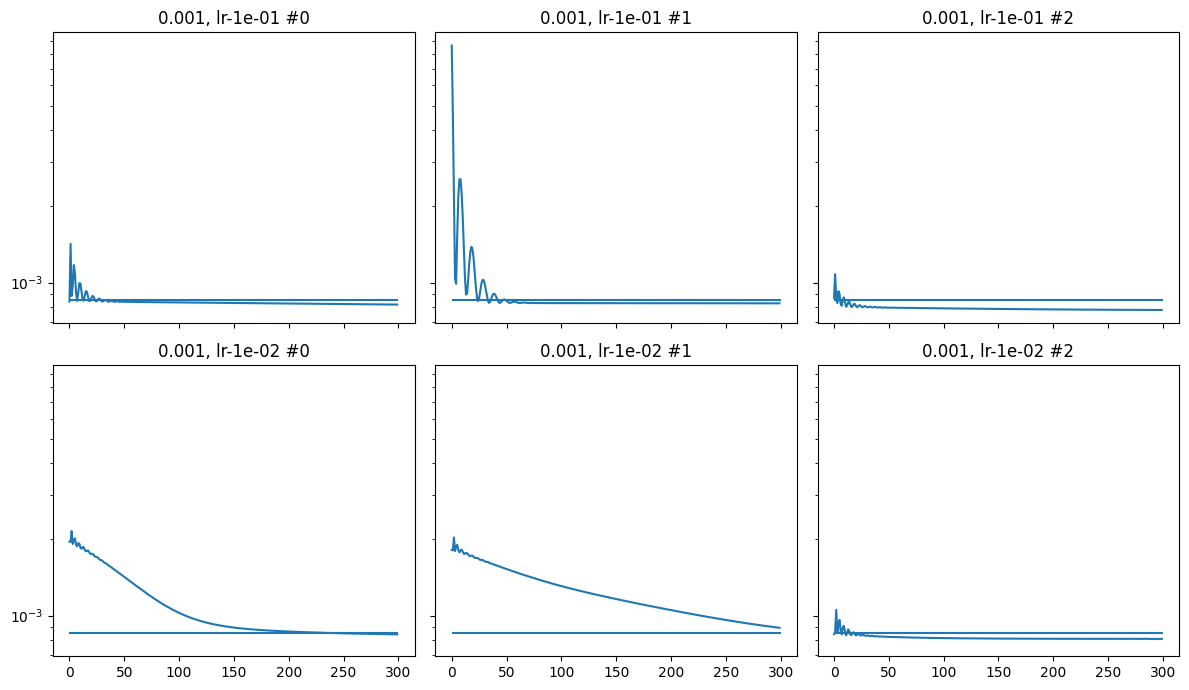

In [58]:
ncols=3
fig, axs = plt.subplots(ncols=ncols, nrows=2, figsize=(12,7), sharey=True, sharex=True)

# axs[0, 0].text(10, 1e-2, f"T_CR {T_CR} T_single {T_single}")
# axs[0, 0].text(10, 10**(-2.5), f"n_params {n_params} tbins {tbins}")

for i,hyp in enumerate(hyper_params):
    seed, lr, n_epochs = hyp
    name = f"data/VQE_partial_H4_after-compile-{seed}-lr-{lr}-tbins-{tbins}_n-epochs-{n_epochs}"
    data = np.load(name + ".npz", allow_pickle=True)
    energy, thetaf = data["energy"], data["theta"]
    energy -= E_exact
    emin = np.min(energy)

    ax = axs[i//ncols, i%ncols]
    ax.plot(energy)
    ax.hlines([E_vqe - E_exact], 0, 300)
    
    ax.set_yscale("log")
    ax.set_title(f"{emin:.3f}, lr-{lr:.0e} #{seed}")
plt.tight_layout()

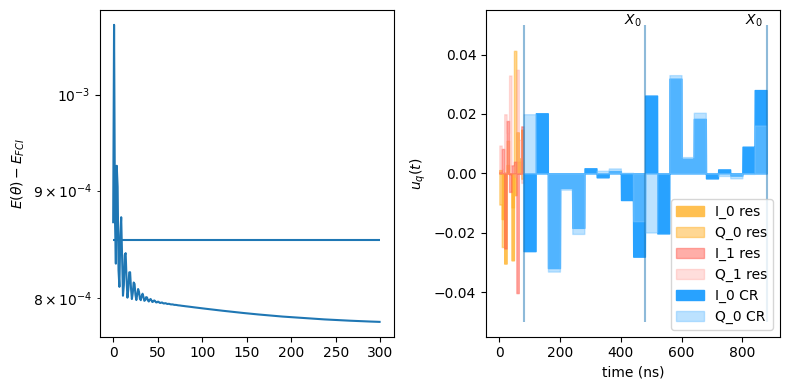

In [63]:
time_stretch = 40.
T_single = 2. * time_stretch
T_CR = 10. * time_stretch

fig, axs = plt.subplots(ncols=2, figsize=(8,4))

seed, lr, n_epochs = 2, 0.1, 300

name = f"data/VQE_partial_H4_after-compile-{seed}-lr-{lr}-tbins-{tbins}_n-epochs-{n_epochs}"
data = np.load(name + ".npz", allow_pickle=True)
energy, thetas = data["energy"], data["theta"]
emin = np.min(energy)

energy -= E_exact

thetaf = thetas[-1]

ax = axs[0]
ax.plot(energy)
ax.hlines([E_vqe - E_exact], 0, len(energy))

# ax.text(100, 10**(-.5), f"$\\theta \\in$ [{np.min(thetaf[:, :tbins]):.1f} {np.max(thetaf[:, :tbins]):.1f}]")

ax.set_yscale("log")
ax.set_ylabel("$E(\\theta) - E_{{FCI}}$")

ax = axs[1]

t0 = np.linspace(0, T_single, 500)
phit = qml.pulse.pwc(T_single)(thetaf[1, tbins:], t0)
V = qml.pulse.pwc(T_single)(thetaf[1, :tbins], t0) / time_stretch
ax.fill_between(t0, np.sin(phit) * V, label="I_0 res", color="#FFC051")
ax.fill_between(t0, np.cos(phit) * V, label="Q_0 res", alpha=0.5, color="#FFB128")

t0 = np.linspace(0, T_single, 500)
phit = qml.pulse.pwc(T_single)(thetaf[0, tbins:], t0)
V = qml.pulse.pwc(T_single)(thetaf[0, :tbins], t0) / time_stretch
ax.fill_between(t0, np.sin(phit) * V, label="I_1 res", alpha=0.5, color="#FF5E52")
ax.fill_between(t0, np.cos(phit) * V, label="Q_1 res", alpha=0.3, color="#FF938B")

t1 = np.linspace(T_single, T_single + T_CR, 500)
phit = qml.pulse.pwc((T_single, T_single + T_CR))(thetaf[2, tbins:], t1)
V = qml.pulse.pwc((T_single, T_single + T_CR))(thetaf[2, :tbins], t1) / time_stretch
ax.fill_between(t1, np.sin(phit) * V, label="I_0 CR", color="#28A2FF")
ax.fill_between(t1, np.cos(phit) * V, label="Q_0 CR", alpha=0.5, color="#7AC6FF")

t1 = np.linspace(T_single + T_CR, T_single + 2*T_CR, 500)
phit = qml.pulse.pwc((T_single + T_CR, T_single + 2*T_CR))(thetaf[2, tbins:], t1)
V = qml.pulse.pwc((T_single + T_CR, T_single + 2*T_CR))(-thetaf[2, :tbins], t1) / time_stretch
ax.fill_between(t1, np.sin(phit) * V, color="#28A2FF")
ax.fill_between(t1, np.cos(phit) * V, alpha=0.5, color="#7AC6FF")

ax.vlines([T_single, T_single + T_CR, T_single + 2*T_CR], -0.05, 0.05, alpha=0.5)
ax.text(T_single + T_CR-70, 0.05, f"$X_0$")
ax.text(T_single + 2*T_CR-70, 0.05, f"$X_0$")
ax.legend(loc=4)
ax.set_xlabel("time (ns)")
ax.set_ylabel("$u_q(t)$")

plt.tight_layout()

In [105]:
import matplotlib as mpl

# Define your custom colors
custom_colors = ['#00b1ffff', '#ff00d9', '#b3e2f7ff', '#ffcff8ff']

# Update the default color cycle using rcParams
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=custom_colors)

Text(0.5, 0, 'epochs')

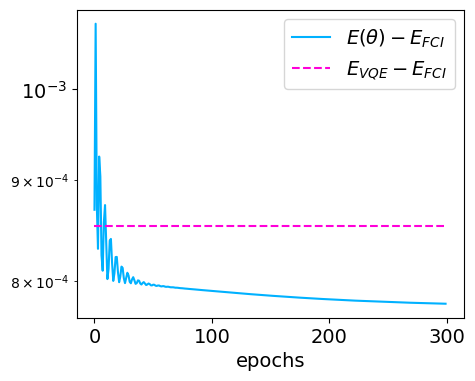

In [115]:
fig, ax = plt.subplots(figsize=(5,4))

seed, lr, n_epochs = 2, 0.1, 300

name = f"data/VQE_partial_H4_after-compile-{seed}-lr-{lr}-tbins-{tbins}_n-epochs-{n_epochs}"
data = np.load(name + ".npz", allow_pickle=True)
energy, thetas = data["energy"], data["theta"]
emin = np.min(energy)

energy -= E_exact

thetaf = thetas[-1]


ax.plot(energy, label = "$E(\\theta) - E_{{FCI}}$", color="#00b1ffff")
ax.hlines([E_vqe - E_exact], 0, len(energy), linestyle="--", label="$E_{{VQE}} - E_{{FCI}}$", color="#ff00d9")
ax.set_yscale("log")
ax.legend(fontsize=14)
ax.tick_params(labelsize=14)
ax.set_xlabel("epochs", fontsize=14)

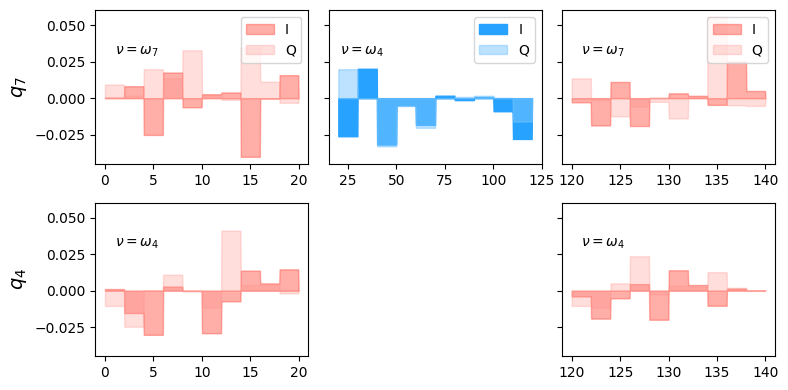

In [93]:
fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(8,4), sharey=True)

seed, lr, n_epochs = 2, 0.1, 300

name = f"data/VQE_partial_H4_after-compile-{seed}-lr-{lr}-tbins-{tbins}_n-epochs-{n_epochs}"
data = np.load(name + ".npz", allow_pickle=True)
energy, thetas = data["energy"], data["theta"]
emin = np.min(energy)

energy -= E_exact

thetaf = thetas[-1]

ax = axs[1, 1]
ax.axis("off")
# ax.plot(energy, label = "$E(\\theta) - E_{{FCI}}$")
# ax.hlines([E_vqe - E_exact], 0, len(energy))
# ax.set_yscale("log")
# ax.legend()

ax = axs[0, 0]

t0 = np.linspace(0, T_single, 500)
phit = qml.pulse.pwc(T_single)(thetaf[0, tbins:], t0)
V = qml.pulse.pwc(T_single)(thetaf[0, :tbins], t0) / time_stretch
ax.fill_between(t0, np.sin(phit) * V, label="I", alpha=0.5, color="#FF5E52")
ax.fill_between(t0, np.cos(phit) * V, label="Q", alpha=0.3, color="#FF938B")
ax.legend()
ax.text(1, 0.03, "$\\nu = \\omega_7$")
ax.set_ylabel("$q_7$", fontsize=14)

ax = axs[1, 0]

t0 = np.linspace(0, T_single, 500)
phit = qml.pulse.pwc(T_single)(thetaf[1, tbins:], t0)
V = qml.pulse.pwc(T_single)(thetaf[1, :tbins], t0) / time_stretch
ax.fill_between(t0, np.sin(phit) * V, label="I", alpha=0.5, color="#FF5E52")
ax.fill_between(t0, np.cos(phit) * V, label="Q", alpha=0.3, color="#FF938B")
ax.text(1, 0.03, "$\\nu = \\omega_4$")
ax.set_ylabel("$q_4$", fontsize=14)

ax = axs[0, 1]

t1 = np.linspace(T_single, T_single + T_CR, 500)
phit = qml.pulse.pwc((T_single, T_single + T_CR))(thetaf[2, tbins:], t1)
V = qml.pulse.pwc((T_single, T_single + T_CR))(thetaf[2, :tbins], t1) / time_stretch
ax.fill_between(t1, np.sin(phit) * V, label="I", color="#28A2FF")
ax.fill_between(t1, np.cos(phit) * V, label="Q", alpha=0.5, color="#7AC6FF")
ax.legend()
ax.text(21, 0.03, "$\\nu = \\omega_4$")

ax = axs[0, 2]

t0 = np.linspace(T_CR + T_single, T_CR + 2*T_single, 500)
phit = qml.pulse.pwc((T_CR + T_single, T_CR + 2*T_single))(thetaf[3, tbins:], t0)
V = qml.pulse.pwc((T_CR + T_single, T_CR + 2*T_single))(thetaf[3, :tbins], t0) / time_stretch
ax.fill_between(t0, np.sin(phit) * V, label="I", alpha=0.5, color="#FF5E52")
ax.fill_between(t0, np.cos(phit) * V, label="Q", alpha=0.3, color="#FF938B")
ax.legend()
ax.text(T_CR + T_single + 1, 0.03, "$\\nu = \\omega_7$")

ax = axs[1, 2]

t0 = np.linspace(T_CR + T_single, T_CR + 2*T_single, 500)
phit = qml.pulse.pwc((T_CR + T_single, T_CR + 2*T_single))(thetaf[4, tbins:], t0)
V = qml.pulse.pwc((T_CR + T_single, T_CR + 2*T_single))(thetaf[4, :tbins], t0) / time_stretch
ax.fill_between(t0, np.sin(phit) * V, label="I", alpha=0.5, color="#FF5E52")
ax.fill_between(t0, np.cos(phit) * V, label="Q", alpha=0.3, color="#FF938B")
ax.text(T_CR + T_single + 1, 0.03, "$\\nu = \\omega_4$")

plt.tight_layout()